# Cleaned vs Dirty | Kaggle

In [1]:
import torch
import torchvision
from torchvision import transforms, models
from torchvision.utils import save_image
import pytorch_lightning
import random
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import cv2
from tqdm import tqdm
from copy import deepcopy

print(torch.__version__)
print(torchvision.__version__)
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)
print(sns.__version__)

1.13.1
0.14.0a0
1.23.1
1.4.3
1.0.1
0.11.2


In [2]:
seed = 123

os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    np.random.seed(seed)
    random.seed(seed)

g = torch.Generator()
g.manual_seed(2147483647)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Image Processing

In [4]:
!rm -rf /tmp/working

In [5]:
class_names = ['cleaned', 'dirty']

dirs = {
    'root': '/tmp/working',
    'train': 'train',
    'val': 'val',
    'test': 'test',
    'cheat': 'cheat',  # test images processed by hand in order to avoid excessive submissions
    'source': './plates',
}

shutil.copytree(os.path.join(dirs['source'], dirs['train']), 
                os.path.join(dirs['root'], dirs['val']),
                dirs_exist_ok=True)

shutil.copytree(os.path.join(dirs['source'], dirs['cheat']), 
                os.path.join(dirs['root'], dirs['test']),
                dirs_exist_ok=True)

'/tmp/working/test'

In [6]:
import imgaug as ia
from imgaug import augmenters as iaa
import imgaug.parameters as iap
from skimage.io import imread_collection
import imageio

print(ia.__version__)

wise_affine = iaa.PiecewiseAffine(scale=(0.01, 0.04))
affine = iaa.Affine(translate_percent={"x": -0.1, "y": -0.1}, mode=ia.ALL, cval=(0, 255))
cutout = iaa.Cutout(nb_iterations=(1, 10), size=0.05, fill_mode="gaussian", fill_per_channel=True)
coarse_dropout = iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.25), per_channel=0.5)

aug_lst = [
    wise_affine,
    affine,
    cutout,
    coarse_dropout,
]

0.4.0


In [7]:
def make_augmentation(aug_lst, src, dst):
    for aug in aug_lst:       
        im_collection = imread_collection(src +'/'+ '*.jpg')
        files = os.listdir(src)
        for idx, file in enumerate(files):
            img = aug(image=im_collection[idx])
            transform = transforms.ToTensor()
            img_torch = transform(img)
            aug_name = aug.__class__.__name__
            file = dst +'/'+ file.replace('.jpg', '_'+ aug_name +'.jpg')
            save_image(img_torch, file)

In [8]:
def make_train(aug_lst):
    for class_name in class_names:
        src = os.path.join(dirs['root'], dirs['val'], class_name)
        dst = os.path.join(dirs['root'], dirs['train'], class_name)
        os.makedirs(dst, exist_ok=True)
        make_augmentation(aug_lst, src, dst)

In [9]:
make_train(aug_lst)

## Dataloaders

In [30]:
train_transforms =  transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class_names = ['cleaned', 'dirty']

root_dir = dirs['root']
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_dir, val_transforms)

batch_size = 64
num_workers = 4

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

test_dataloader  = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)

print('{}\t{}\t{}'.format('Dataset', 'Batches', 'Pictures'))
print('-' * 24)
print('{}\t{}\t{}'.format('train', len(train_dataloader), len(train_dataset)))
print('{}\t{}\t{}'.format('val', len(val_dataloader), len(val_dataset)))
print('{}\t{}\t{}'.format('test', len(test_dataloader), len(test_dataset)))

Dataset	Batches	Pictures
------------------------
train	3	160
val	1	40
test	4	200


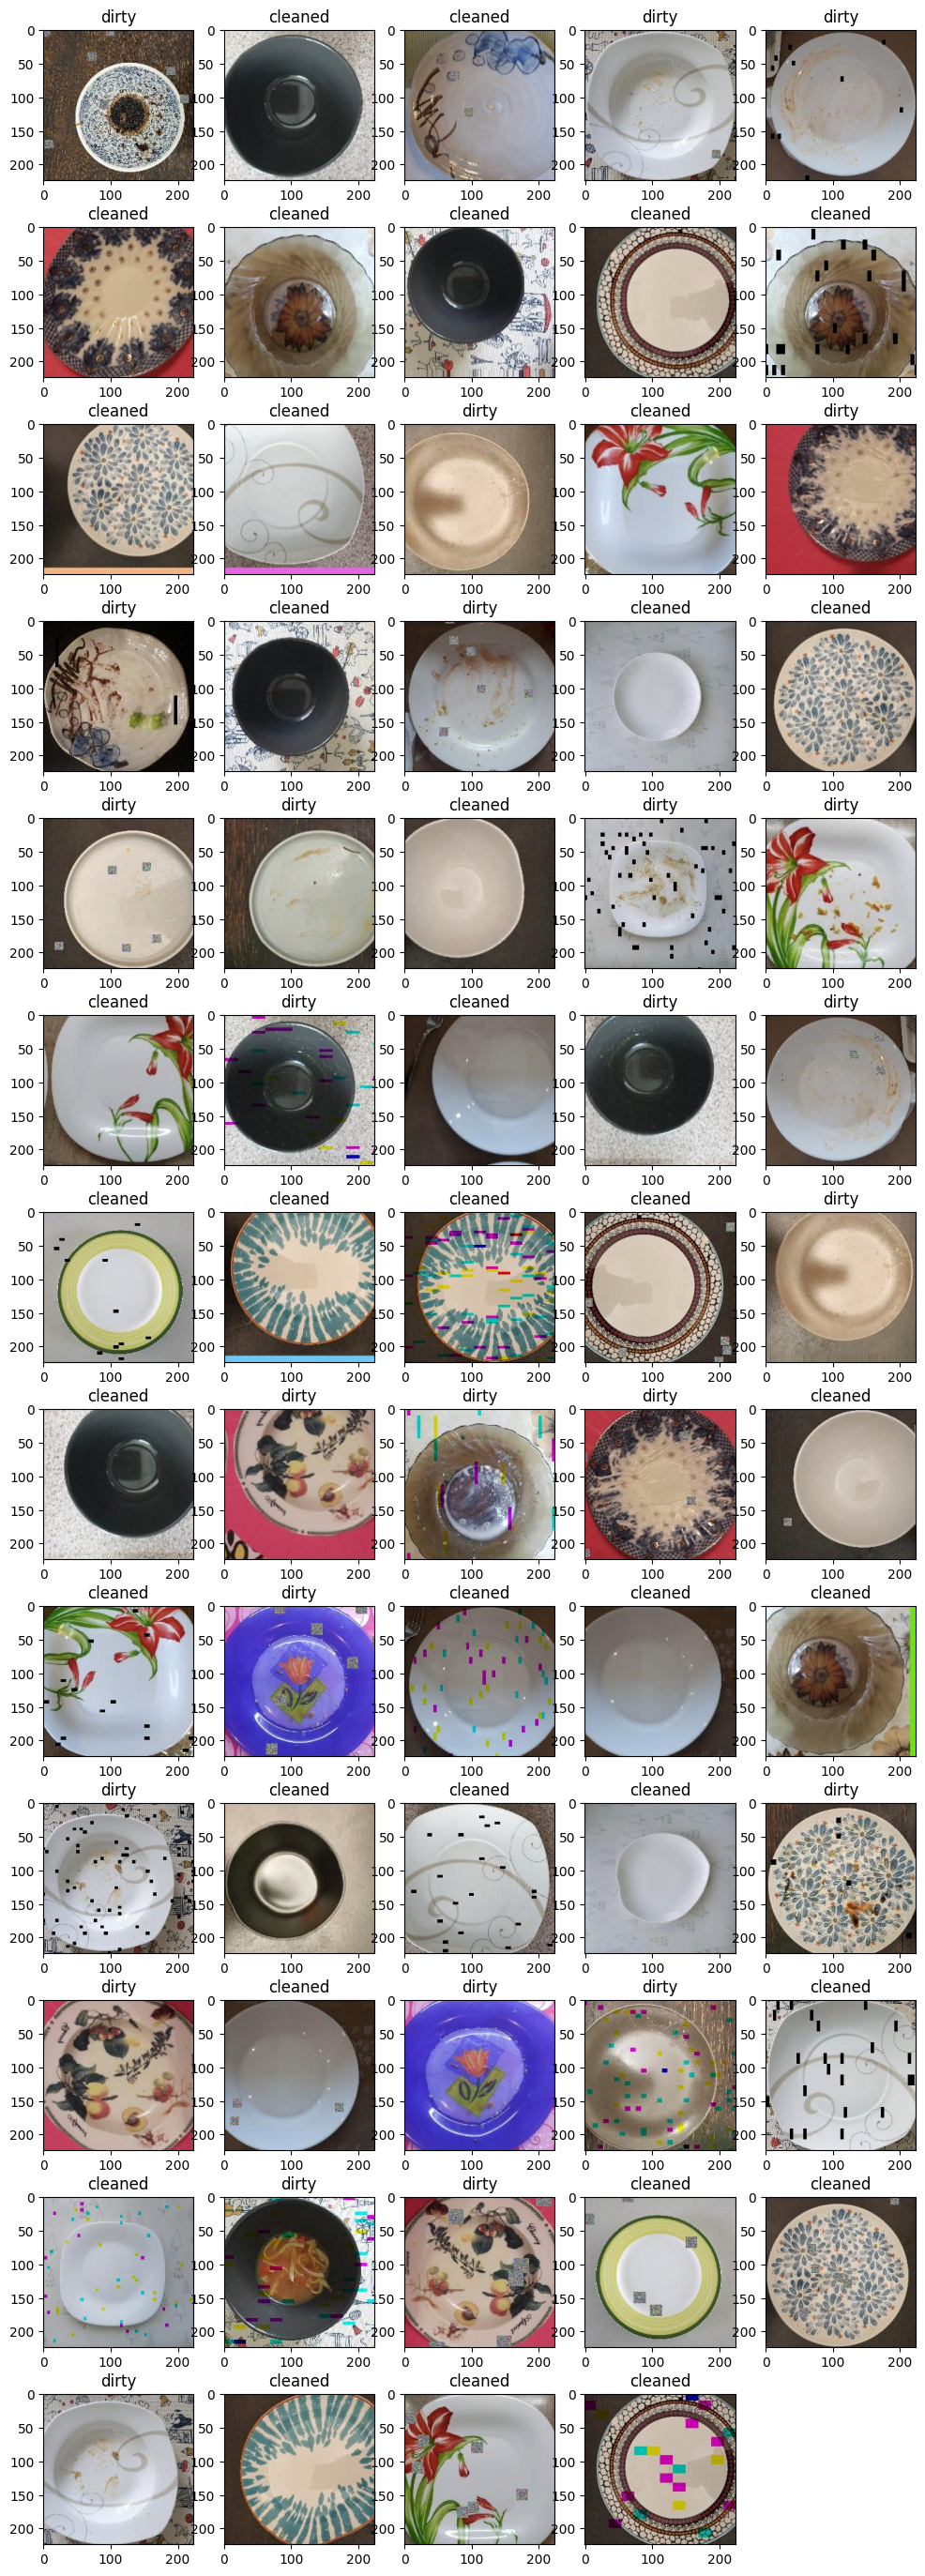

In [31]:
plt.rcParams['figure.figsize'] = (12, 35)

X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

ncol = 5
nrow = len(X_batch)//ncol + 1

for idx, img in enumerate(X_batch):
    plt.subplot(nrow, ncol, idx+1)
    plt.title(class_names[y_batch[idx].item()])
    img = img.permute(1, 2, 0).numpy() * std + mean
    img = np.array(img/np.amax(img)*255, np.int32)
    plt.imshow(img)

## Pretrained Models

In [12]:
class MyResNet18v2(torch.nn.Module):
    def __init__(self):
        super(MyResNet18v2, self).__init__()
        self.net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Sigmoid(),
            torch.nn.Linear(128, 2),
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

## Training Algorithm and Functions

In [13]:
def train_model(model, loss, optimizer, scheduler, early_stopping_epoch=30, num_epochs=1000, progress=True): 
    model = model.to(device)
    loss_history = []
    acc_history = []
    best_loss = 0
    
    for epoch in tqdm(range(num_epochs), disable=not progress):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train() # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval() # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data
            for inputs, labels in dataloader: # input is a 4d tensor, target is 1d
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # Backward and optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean().item()
                
            scheduler.step()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'val':
                loss_history.append(epoch_loss)
                acc_history.append(epoch_acc)
        
        # Creating checkpoints
        if epoch_loss < best_loss or not epoch:
            best_loss = epoch_loss
            best_acc = epoch_acc
            best_epoch = epoch
            best_model_state = deepcopy(model.state_dict())
        
        # Early stopping and restoring checkpoint
        if epoch - best_epoch == early_stopping_epoch:
            model.load_state_dict(best_model_state)
            break
    
    if progress:
        print('Best Loss: {:.8f} Best Acc: {:.2f} on Epoch {}'\
              .format(best_loss, best_acc, best_epoch))
    
    return model, best_loss, best_acc

In [14]:
def torch_optimizer(optimizer, **params):
    switcher = {
        'Adam': torch.optim.Adam,
        'SGD': torch.optim.SGD,
    }
    return switcher[optimizer](**params)

def train(model, optimizer='Adam', step_size=7 , step_gamma=0.1, progress=True, **optim_params):
    loss = torch.nn.CrossEntropyLoss()
    optim_params['params'] = model.parameters()
    optimizer = torch_optimizer(optimizer, **optim_params)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=step_gamma)
    model, loss_value, acc = train_model(model, loss, optimizer, scheduler, progress=progress)    
    return model, loss_value, acc

In [15]:
def predict(model, dataloader, progress=False):
    model.eval()    
    predictions = []
    true_labels = []

    for inputs, labels in tqdm(dataloader, disable=not progress):
        inputs = inputs.to(device)
        
        with torch.set_grad_enabled(False):
            preds = model(inputs)

        predictions.append(torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        true_labels.append(labels.numpy())
    
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    return predictions, true_labels

def test(model, dataloader):
    pred, true = predict(model, dataloader)
    return sum(true == (pred > 0.5)) / len(true)

## Hyperparameters Tuning

In [27]:
from hyperopt import fmin, tpe, hp, STATUS_OK
from hyperopt.early_stop import no_progress_loss
import json

def hyperopt_obj(params):
    pretty = json.dumps(params, indent=4)
    print(pretty)
    
    optimizer = params['optimizer']
    step_size = params['step_size']
    step_gamma = params['step_gamma']
    del params['optimizer']
    del params['step_size']
    del params['step_gamma']
    
    model, _, _ = train(net(), optimizer, step_size, step_gamma, progress=False, **params)
    acc = test(model, test_dataloader)
    print('Test Acc: {:.3f}'.format(acc))
        
    return {'loss': -np.mean(acc),
            'status': STATUS_OK,
    }

In [32]:
space = {
    'lr': hp.uniform('lr', 0.01, 0.10),
    'weight_decay': hp.uniform('weight_decay', 1e-4, 9e-4),
    'step_size': hp.quniform('step_size', 10, 20, 1),
    'step_gamma': hp.uniform('step_gamma', 0.2, 0.7),
}

space = hp.choice('optimizer', [
    {**{'optimizer': 'SGD', 
        'momentum': hp.uniform('momentum', 0.2, 0.7),}, 
     **space},
])

net = MyResNet18v2

best = fmin(fn=hyperopt_obj, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=300, 
            early_stop_fn=no_progress_loss(50),
)
best_params = best.copy()
best_params['optimizer'] = 'SGD'

print('\nSearch Result:')
print(json.dumps(best_params, indent=4))

{                                                                                                                               
    "lr": 0.0700229401165756,
    "momentum": 0.4932776304436009,
    "optimizer": "SGD",
    "step_gamma": 0.5785997810343652,
    "step_size": 17.0,
    "weight_decay": 0.0007751712053317018
}
Test Acc: 0.830                                                                                                                 
{                                                                                                                               
    "lr": 0.07176877093437421,
    "momentum": 0.37706205537331106,
    "optimizer": "SGD",
    "step_gamma": 0.5617193244988039,
    "step_size": 19.0,
    "weight_decay": 0.000719833244025025
}
Test Acc: 0.780                                                                                                                 
{                                                                                            

## Prediction

In [33]:
shutil.copytree(os.path.join(dirs['source'], dirs['test']), 
                os.path.join(dirs['root'], 'submit/unknown'), 
                dirs_exist_ok=True)

'/tmp/working/submit/unknown'

In [40]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
submit_dir = os.path.join(root_dir, 'submit')
submit_dataset = ImageFolderWithPaths(submit_dir, val_transforms)

submit_dataloader = torch.utils.data.DataLoader(
    submit_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [71]:
def predict_submission(model, dataloader, progress=False):
    model.eval()
    
    predictions = []
    img_paths = []

    for inputs, labels, paths in tqdm(dataloader, disable=not progress):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            preds = model(inputs)

        predictions.append(torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        img_paths.extend(paths)

    predictions = np.concatenate(predictions)
    img_paths = list(map(lambda x: x.split('/')[-1].split('.')[0], img_paths))
    out = pd.DataFrame(zip(predictions, img_paths), columns=['prob', 'id']).set_index('id')
    
    return out

In [55]:
model, _, _ = train(net(), **best_params)
print(test(model, test_dataloader))

  7%|█████▊                                                                                   | 66/1000 [00:51<12:13,  1.27it/s]


Best Loss: 0.44645604 Best Acc: 0.88 on Epoch 36
0.885


In [92]:
submit = predict_submission(model, submit_dataloader)
submit['label'] = submit['prob'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')

In [93]:
submit.drop('prob', axis=1).to_csv('submission.csv')

In [35]:
submission_df.drop(['label', 'state_proba'], axis=1)\
.set_index('id')\
.rename(columns={'prediction': 'label'})\
.to_csv('submission_net50v2.csv')

Score on [Kaggle](https://www.kaggle.com/competitions/platesv2): 0.87634